In [9]:
# imports & paths

import json
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from pathlib import Path
import sys

CURRENT_DIR = Path.cwd()

PROJECT_ROOT = None
SRC_DIR = None

for base in [CURRENT_DIR, *CURRENT_DIR.parents]:
    cand = base / "server" / "src"
    if cand.exists():
        PROJECT_ROOT = base
        SRC_DIR = cand
        break

if SRC_DIR is None:
    raise RuntimeError(f"server/src bulunamadı, CURRENT_DIR = {CURRENT_DIR}")

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# Çıktı klasörleri
OUTPUTS_DIR = PROJECT_ROOT / "server" / "outputs"
JSON_DIR = OUTPUTS_DIR / "json"

# --- Project moduls ---
from data_loading import load_clean_data
from models_baseline import (
    naive_forecast_last_value,
    moving_average_forecast,
    train_test_split_series,
)
from portfolio import build_recommended_portfolios


In [10]:
# Cell 3: Load SPY clean data and train/test split

# SPY temiz fiyat serisini yükle
df_spy = load_clean_data("SPY")

# Date index'e al
if "Date" in df_spy.columns:
    df_spy = df_spy.set_index("Date")

df_spy = df_spy.sort_index()
spy_series = df_spy["Close"].astype(float)

print("SPY series length:", len(spy_series))
print("SPY date range:", spy_series.index.min(), "->", spy_series.index.max())

# Time-based split (same idea as models_ml.py / baseline)
SPLIT_DATE = "2023-01-01"  # istersen 2022-12-31 kullan, önemli olan mantık

spy_train, spy_test = train_test_split_series(spy_series, split_date=SPLIT_DATE)

print("Train length:", len(spy_train), "Test length:", len(spy_test))
print("Train last date:", spy_train.index.max(), "Test first date:", spy_test.index.min())

SPY series length: 2521
SPY date range: 2015-01-02 00:00:00 -> 2024-12-31 00:00:00
Train length: 2019 Test length: 502
Train last date: 2022-12-30 00:00:00 Test first date: 2023-01-03 00:00:00


In [11]:
# Cell 4: Baseline forecasts (naive & moving average) and metrics

horizon = len(spy_test)

# Naive: son değeri test boyunca sabit tahmin
baseline_naive = naive_forecast_last_value(spy_train, horizon=horizon)

# Moving average: son 30 gün ortalamasını sabit tahmin
baseline_ma = moving_average_forecast(spy_train, window=30, horizon=horizon)

y_true = spy_test.values

def compute_metrics(y_true, y_pred, name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}")
    return mae, rmse

mae_naive, rmse_naive = compute_metrics(y_true, baseline_naive, name="Naive baseline")
mae_ma, rmse_ma = compute_metrics(y_true, baseline_ma, name="MovingAverage baseline")

Naive baseline: MAE=102.2063, RMSE=120.9700
MovingAverage baseline: MAE=92.0465, RMSE=112.2849


In [12]:
# Cell 5: ARIMA model on SPY

# Basit bir ARIMA(1,1,1) modeli. İstersen order'ı değiştirip oynayabilirsin.
arima_order = (1, 1, 1)

arima_model = ARIMA(spy_train, order=arima_order)
arima_result = arima_model.fit()

print(arima_result.summary())

# Test horizon kadar ileri tahmin
arima_forecast = arima_result.forecast(steps=horizon)

mae_arima, rmse_arima = compute_metrics(y_true, arima_forecast, name=f"ARIMA{arima_order}")

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2019
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5469.964
Date:                Wed, 03 Dec 2025   AIC                          10945.928
Time:                        11:58:19   BIC                          10962.758
Sample:                             0   HQIC                         10952.105
                               - 2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3538      0.090     -3.915      0.000      -0.531      -0.177
ma.L1          0.2609      0.095      2.761      0.006       0.076       0.446
sigma2        13.2406      0.194     68.256      0.0

/Users/omerfsaribal/Uni/5th-Term/FinTech/Project/wealthflow/python-server/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/omerfsaribal/Uni/5th-Term/FinTech/Project/wealthflow/python-server/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/omerfsaribal/Uni/5th-Term/FinTech/Project/wealthflow/python-server/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/omerfsaribal/Uni/5th-Term/FinTech/Pr

In [13]:
# Cell 6: LSTM helpers (series -> supervised sequences, model builder)

def create_lstm_sequences(series: pd.Series, lookback: int = 60):
    """
    series: pandas Series of prices (train kısmı).
    lookback: kaç günlük history ile 1 gün sonrası tahmini yapılacak.
    """
    values = series.values.reshape(-1, 1).astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i - lookback:i, 0])
        y.append(scaled[i, 0])

    X = np.array(X)
    y = np.array(y)

    # reshape to (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y, scaler


def build_lstm_model(lookback: int = 60):
    model = Sequential()
    model.add(LSTM(32, input_shape=(lookback, 1)))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
    return model

In [14]:
# Cell 7: Train LSTM on SPY and multi-step forecast for test period

LOOKBACK = 60

# Train set üzerinden supervised veri oluştur
X_train, y_train_seq, scaler = create_lstm_sequences(spy_train, lookback=LOOKBACK)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_seq.shape)

lstm_model = build_lstm_model(lookback=LOOKBACK)

early_stop = EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True,
)

history = lstm_model.fit(
    X_train,
    y_train_seq,
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop],
)

# Multi-step forecast:
#  - Başlangıç penceresi: train'in son LOOKBACK günü
#  - Her adımda 1 gün tahmin et, pencereyi kaydır, scaled space'te çalış, sonra inverse transform ile price'a çevir.

train_values = spy_train.values.reshape(-1, 1).astype(float)
train_scaled = scaler.transform(train_values)
history_scaled = list(train_scaled.flatten())

lstm_forecast = []

for i in range(horizon):
    if len(history_scaled) < LOOKBACK:
        # yeterli history yoksa boş geç
        break

    x_input = np.array(history_scaled[-LOOKBACK:])
    x_input = x_input.reshape((1, LOOKBACK, 1))

    yhat_scaled = lstm_model.predict(x_input, verbose=0)[0, 0]

    # history'ye ekle
    history_scaled.append(yhat_scaled)

    # original price scale'e çevir
    yhat_price = scaler.inverse_transform([[yhat_scaled]])[0, 0]
    lstm_forecast.append(yhat_price)

# LSTM forecast uzunluğu test ile aynı olmalı (aksi halde min len'e göre kırparız)
min_len = min(len(y_true), len(lstm_forecast))
y_true_lstm = y_true[:min_len]
lstm_forecast = np.array(lstm_forecast[:min_len])

mae_lstm, rmse_lstm = compute_metrics(y_true_lstm, lstm_forecast, name="LSTM")

X_train shape: (1959, 60, 1)
y_train shape: (1959,)
Epoch 1/20


/Users/omerfsaribal/Uni/5th-Term/FinTech/Project/wealthflow/python-server/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0661
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4467e-04
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4877e-04
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9217e-04
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8297e-04
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9130e-04
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3087e-04
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9990e-04
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8893e-04
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7833e-04
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4607e-04
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3170e-04
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1986e-04
Epoch 15/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

In [15]:
# Cell 8: Comparison table for MAE and RMSE

metrics_df = pd.DataFrame(
    {
        "MAE": {
            "Naive": mae_naive,
            "MovingAverage": mae_ma,
            "ARIMA": mae_arima,
            "LSTM": mae_lstm,
        },
        "RMSE": {
            "Naive": rmse_naive,
            "MovingAverage": rmse_ma,
            "ARIMA": rmse_arima,
            "LSTM": rmse_lstm,
        },
    }
)

metrics_df

,MAE,RMSE
Naive,102.206275,120.970010
MovingAverage,92.046535,112.284885
ARIMA,101.998541,120.792985
LSTM,58.484625,77.692983


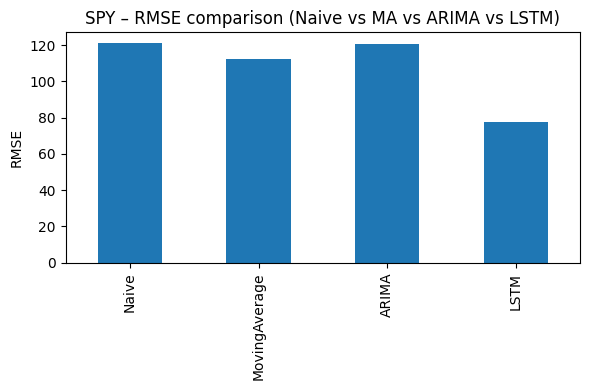

In [16]:
# Optional: bar plot for RMSE comparison

plt.figure(figsize=(6, 4))
metrics_df["RMSE"].plot(kind="bar")
plt.title("SPY – RMSE comparison (Naive vs MA vs ARIMA vs LSTM)")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

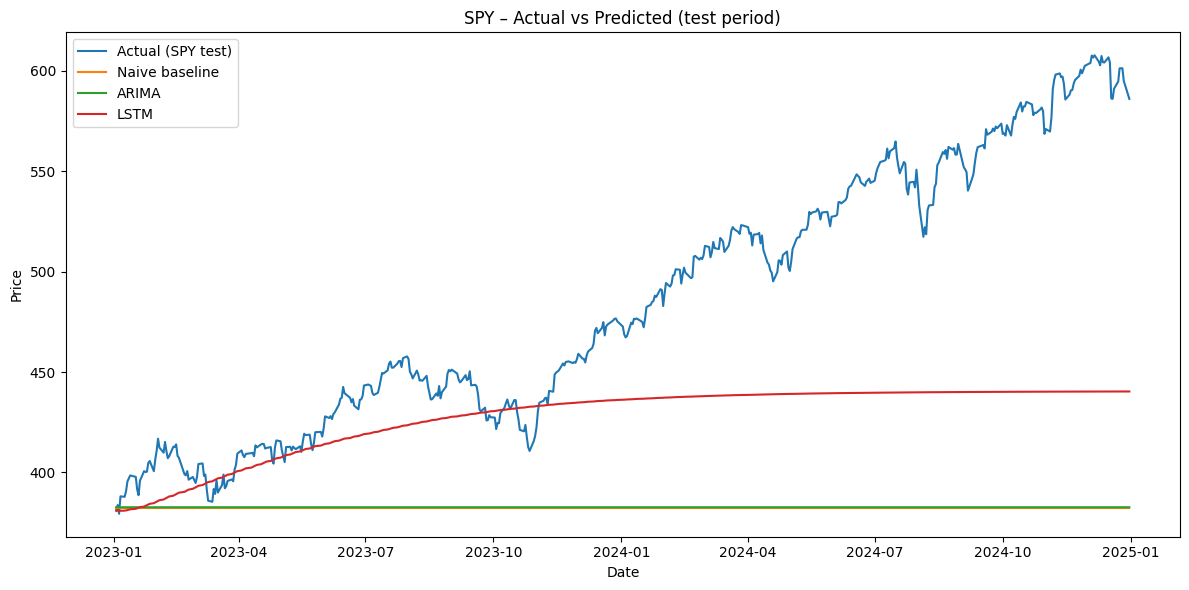

In [17]:
# Cell 9: Real vs predicted prices for SPY (test set)

plt.figure(figsize=(12, 6))
plt.plot(spy_test.index[:len(y_true_lstm)], y_true_lstm, label="Actual (SPY test)")
plt.plot(spy_test.index[:len(baseline_naive)], baseline_naive[:len(y_true_lstm)], label="Naive baseline")
plt.plot(spy_test.index[:len(arima_forecast)], arima_forecast[:len(y_true_lstm)], label="ARIMA")
plt.plot(spy_test.index[:len(lstm_forecast)], lstm_forecast, label="LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("SPY – Actual vs Predicted (test period)")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Cell 10: Compare baseline forecasts vs ML-enhanced forecasts

with (JSON_DIR / "forecasts_baseline.json").open("r", encoding="utf-8") as f:
    forecasts_baseline = json.load(f)

with (JSON_DIR / "forecasts.json").open("r", encoding="utf-8") as f:
    forecasts_ml = json.load(f)

tickers = ["AAPL", "MSFT", "SPY", "QQQ", "TLT", "GLD"]

rows = []
for t in tickers:
    base = forecasts_baseline.get(t, {})
    ml = forecasts_ml.get(t, {})

    rows.append(
        {
            "ticker": t,
            "base_ret_30d": base.get("expected_return_30d"),
            "base_vol_30d": base.get("expected_vol_30d"),
            "ml_ret_30d": ml.get("expected_return_30d"),
            "ml_vol_30d": ml.get("expected_vol_30d"),
        }
    )

forecasts_compare_df = pd.DataFrame(rows).set_index("ticker")
forecasts_compare_df

,base_ret_30d,base_vol_30d,ml_ret_30d,ml_vol_30d
ticker,,,,
AAPL,0.051300,0.059158,0.051300,0.059158
MSFT,0.009241,0.074093,0.009241,0.074093
SPY,0.012240,0.043522,-0.122182,0.005930
QQQ,0.025732,0.059912,-0.000074,0.000114
TLT,-0.043648,0.051298,0.000723,0.000319
GLD,-0.004292,0.056844,-0.004292,0.056844


In [19]:
# Cell 11: Build recommended portfolios (if not already built) and inspect JSON

# Eğer portfolio.py CLI ile zaten çalıştırdıysan, JSON hazırdır.
# Yine de burada bir kez daha build edebiliriz (aynı sonucu üretir).

recs = build_recommended_portfolios()

# JSON'a yaz (idempotent)
portfolio_json_path = JSON_DIR / "portfolio_recommendations_notebook.json"
with portfolio_json_path.open("w", encoding="utf-8") as f:
    json.dump(recs, f, indent=2)

portfolio_json_path, recs

(PosixPath('/Users/omerfsaribal/Uni/5th-Term/FinTech/Project/wealthflow/python-server/server/outputs/json/portfolio_recommendations_notebook.json'),
 {'conservative': {'weights': {'AAPL': 0.11111111111111112,
    'MSFT': 0.11111111111111112,
    'SPY': 0.16666666666666669,
    'QQQ': 0.11111111111111112,
    'TLT': 0.2962962962962963,
    'GLD': 0.2037037037037037},
   'expected_return': -0.014305232673934897,
   'expected_risk': 0.015505159937952139},
  'balanced': {'weights': {'AAPL': 0.16071428571428573,
    'MSFT': 0.16071428571428573,
    'SPY': 0.19642857142857145,
    'QQQ': 0.16071428571428573,
    'TLT': 0.16071428571428573,
    'GLD': 0.16071428571428573},
   'expected_return': -0.014855825094060544,
   'expected_risk': 0.017706775393650624},
  'aggressive': {'weights': {'AAPL': 0.20689655172413793,
    'MSFT': 0.20689655172413793,
    'SPY': 0.18103448275862066,
    'QQQ': 0.20689655172413793,
    'TLT': 0.07758620689655171,
    'GLD': 0.12068965517241378},
   'expected_retu

In [20]:
# Cell 12: Weights table and bar plot for one profile

# recs sözlüğü: profile -> {weights, expected_return, expected_risk}
profiles = list(recs.keys())
profiles

# Weights DataFrame
weights_data = {}
for profile, data in recs.items():
    weights_data[profile] = data["weights"]

weights_df = pd.DataFrame(weights_data)
weights_df

,conservative,balanced,aggressive
AAPL,0.111111,0.160714,0.206897
MSFT,0.111111,0.160714,0.206897
SPY,0.166667,0.196429,0.181034
QQQ,0.111111,0.160714,0.206897
TLT,0.296296,0.160714,0.077586
GLD,0.203704,0.160714,0.120690


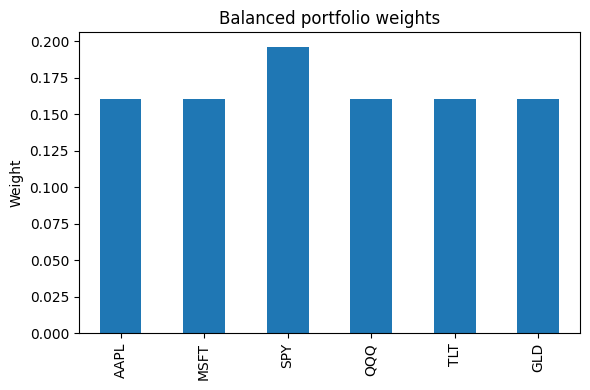

In [21]:
# Bar plot for balanced profile weights

profile_name = "balanced"
w = weights_df[profile_name]

plt.figure(figsize=(6, 4))
w.plot(kind="bar")
plt.title(f"{profile_name.capitalize()} portfolio weights")
plt.ylabel("Weight")
plt.tight_layout()
plt.show()

In [22]:
# Expected return and risk per profile

rows = []
for profile, data in recs.items():
    rows.append(
        {
            "profile": profile,
            "expected_return_30d": data["expected_return"],
            "expected_risk_30d": data["expected_risk"],
        }
    )

portfolio_stats_df = pd.DataFrame(rows).set_index("profile")
portfolio_stats_df

,expected_return_30d,expected_risk_30d
profile,,
conservative,-0.014305,0.015505
balanced,-0.014856,0.017707
aggressive,-0.010071,0.020773


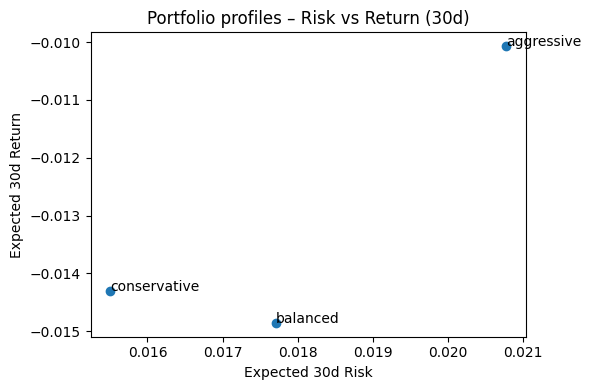

In [23]:
# Risk-return scatter plot

plt.figure(figsize=(6, 4))
plt.scatter(
    portfolio_stats_df["expected_risk_30d"],
    portfolio_stats_df["expected_return_30d"],
)

for profile in portfolio_stats_df.index:
    x = portfolio_stats_df.loc[profile, "expected_risk_30d"]
    y = portfolio_stats_df.loc[profile, "expected_return_30d"]
    plt.annotate(profile, (x, y))

plt.xlabel("Expected 30d Risk")
plt.ylabel("Expected 30d Return")
plt.title("Portfolio profiles – Risk vs Return (30d)")
plt.tight_layout()
plt.show()